# This notebook for preprocessing and deep-learning model model implemented using pytorch of the Devices-Price-Classification-System project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## importing libraries

In [2]:
# installing torchmetrics library to our colab notebook
!pip install torchmetrics

# importing the libraries
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import joblib
import pickle
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.classification import Accuracy, MulticlassF1Score#, ConfusionMatrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# printing pytorch version as this point may affect the reproducability if diffrent pytorch version used
print(f'using version {torch.__version__}')

# This function to be able to reproduce the same numbers in the future, by fixing
# the algorithms parameters that lead to generate the same random numbers

# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    # set seed for python random numbers.
    random.seed(seed)
    # set seed for numpy random numbers.
    np.random.seed(seed)
    # set seed for pytorch random numbers.
    torch.manual_seed(seed)
    # set seed for cuda.
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# select random seed number
seed=7
# call the function
set_random_seed(seed=seed)

using version 2.3.0+cu121


## load data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/maids.cc/data/train - train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/maids.cc/data/test - test.csv")

split the label column from the feature columns

In [5]:
# label column naming it (y)
y = df["price_range"]
#feature columns naming them x
x = df.drop("price_range", axis=1)
#y.shape, x.shape

#### using train test split function to split the training data into training and validation set

In [6]:
from sklearn.model_selection import train_test_split
xtrain_unprocessed, xtest_unprocessed, ytrain, ytest = train_test_split(
    x, y, test_size=0.17, random_state=seed, stratify=y, shuffle=True)

In [7]:
## initializing the one_hot_encoder
#one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
## apply transformation
#ytrain = one_hot_encoder.fit_transform(ytrain_unprocessed)
#ytest = one_hot_encoder.transform(ytest_unprocessed)
##ytrain.shape

we will do all the preprocessing steps using the make_column_transformer this has many advantages, such as we can involve the preprocessing step in the fine tuning process, and we dont need the repeat the same steps for testing data step by step

In [8]:
preprocessor_1 = make_column_transformer((MinMaxScaler(feature_range=(0, 3)), ["ram"]),
                                          remainder="passthrough")

preprocessor_2 = make_column_transformer(
    #(KNNImputer(), slice(0, k)),  # test this choice, but it leads to poor results
     (IterativeImputer(random_state=seed, tol=1e-5, max_iter=55), slice(0, 20)),
     remainder="passthrough")

preprocessor_3 = make_column_transformer((StandardScaler(), slice(1, 20)),
                                         remainder="passthrough")

# by the way deep-learning can deal with unscaled features, but anyway i did StandardScaler, MinMaxScaler steps

#### machine learning is a search problem

In [9]:

pipe = make_pipeline(preprocessor_1, preprocessor_2, preprocessor_3)

# apply the needed transformations over the training data
xtrain = pipe.fit_transform(xtrain_unprocessed)

# apply the needed transformations over the testing data
xtest = pipe.transform(xtest_unprocessed)

In [10]:
class CollectedData(Dataset):
    '''create the class to deal with the data convert them into torch tensors, getting the data item and getting the length of the data'''

    def __init__(self, x, y):
        self.data = torch.tensor(x, dtype=torch.float32)
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]


    def __getitem__(self, idx):
        '''return the data sample given the index'''

        # return the features and the corresponding label of the given index
        # i convert them to float to solve an error appears while train the model
        return (self.data[idx].float(), self.label[idx]#.float()
        )

    def __len__(self):
        '''function to return the length of the dataset'''

        # return the length of the dataset
        return self.n_smpl

#compine the features and the corresponding labels into one object
train_set = CollectedData(xtrain, ytrain)

#compine the features and the corresponding labels into one object
test_set = CollectedData(xtest, ytest)

In [11]:
## almost the same result of the brevious cell, using another way.
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels = torch.tensor(ytrain.values.astype(np.float32))
# # test_labels = torch.tensor(ytest.values.astype(np.float32))
# train_input = torch.tensor(xtrain.values.astype(np.float32))
# # test_input = torch.tensor(xtest.values.astype(np.float32))

# train_set = TensorDataset(train_input, train_labels)
# # test_set = TensorDataset(test_input, test_labels)


In [13]:
num_classes=4

#initializing accuracy function
accuracy = Accuracy(task="multiclass", num_classes=num_classes)

#initializing mean-square-error function
cross_entropy_loss = nn.CrossEntropyLoss()

#initializing f1score function
f1score = MulticlassF1Score(num_classes=num_classes, average='micro')

# evaluate the performance using the accuracy, mean-square-error and f1score pytorch functions
@torch.no_grad()
def evaluate_model(model, data_loader):
    '''this function is to evaluate the performance of the model using R2Score and mean-square-error pytorch functions'''

    # Set the model to eval mode while validating
    model.eval()

    # initialize the labels and preds and transfering them to device(cpu or gpu)
    labels = torch.tensor([], dtype=torch.long).to(device)
    predictions = torch.tensor([], dtype=torch.float).to(device)

    # starting the loop over data
    for features, label in data_loader:

        # transfering data to cuda
        features = features.to(device=device)

        # concatenate all the labels
        labels = torch.cat((labels, label), dim=0)
        #print(f"labels shape:-- {labels.shape}")

        # get the model predictions of the given data and flatten them
        preds = model(features)#.argmax(dim=1).reshape(-1) # the preds.shape must be [number_of_samples] incase of some metrics
        predictions = torch.cat((predictions, preds), dim=0)

    #print(f"preds shape  {preds.shape}")
    #print(f"Shape of predictions: {predictions.shape}")
    #print(f"Shape of labels: {labels.shape}")
        #print(f"dtype of labels: {labels.dtype}")

    # calculate cross_entropy_loss
    cross_entropy_loss_evaluation = cross_entropy_loss(predictions, labels)

    # calculate accuracy
    accuracy_evaluation = accuracy(predictions.argmax(dim=1), labels)

    # calculate f1score
    f1score_evaluation = f1score(predictions, labels)

    #print(f1score_evaluation.shape, accuracy_evaluation.shape, cross_entropy_loss_evaluation.shape)
    #print(f1score_evaluation, accuracy_evaluation, cross_entropy_loss_evaluation)

    # evaluation metrics
    model_evaluations = np.array([accuracy_evaluation,
                                  cross_entropy_loss_evaluation,
                                  f1score_evaluation])

    # return the model to the train mode.
    model.train()

    # return the model_evaluations result
    return model_evaluations

#evaluate_model(model, data_loader=test_loader)

In [22]:
class network(nn.Module):
    '''create the structure of the model'''

    def __init__(self, in_features=20, out_features=4):
        '''like a class constructor function or initialization'''

        super().__init__()
        # the fully connected layers
        self.fc1 = nn.Linear(in_features, 21)
        self.fc2 = nn.Linear(21, 21)
        self.fc3 = nn.Linear(21, 21)
        self.fc4 = nn.Linear(21, 21)
        self.fc5 = nn.Linear(21, 21)
        self.fc6 = nn.Linear(21, 21)
        self.fc7 = nn.Linear(21, 21)
        self.fc8 = nn.Linear(21, 21)
        self.fc9 = nn.Linear(21, 21)
        self.fc10 = nn.Linear(21, 21)
        self.fc11 = nn.Linear(21, out_features)

        # initialize the model parameters(weights, bias)
        self.initialize_weights()

    def forward(self, features):
        '''this the forward path of the model'''
        # i used different activation functions to enable the model to select the output without limitation of any activation function
        out = F.leaky_relu(self.fc1(features))
        out = F.relu(self.fc2(out))
        out = F.tanh(self.fc3(out))
        out = F.relu(self.fc4(out))
        #out = F.tanh(self.fc5(out))
        #out = F.relu(self.fc6(out))
        #out = F.tanh(self.fc7(out))
        #out = F.relu(self.fc8(out))
        #out = F.tanh(self.fc9(out))
        #out = F.relu(self.fc10(out))
        out =(#F.softmax(
              self.fc11(out)
              #, dim=1)
             )
        return out

    def initialize_weights(self):
        '''initialize the model parameters(W, b)'''

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

# initializing the model and convert it to device(gpu or cpu)
model = network().to(device)

In [23]:
 # define the training function.
def train_model(num_epochs, data_loader):

    # set the number of batches to be the length of 'data_loader'
    num_batches = len(data_loader)

    # print the hyperparameters informations that the model going to train based on.
    print(f"""batch_size = {batch_size} \n starting learning rate = {learning_rate} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")

    # initialize lists to save the training and testing validation progress to be able to plot the results later
    evaluations_progress = np.empty(shape=(num_epochs, 2, 3))

    # return the model to the train mode.
    model.train()

    # start the epochs loop
    for epoch in range(num_epochs):

        # printing out the time which the model starts, to be able to calculate the minuts it take
        start_time = time.time()

        # initialize progress function that display the progress of the training.
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)

        # starting the training loop for each epoch
        for batch_idx, (features, labels) in progress:

            # convert data to device
            features = features.to(device=device)

            # convert labels to device
            labels = labels.to(device=device)

            # calculate the predictions.
            output = model(features)#.argmax(dim=1).reshape(-1).float()   # reshape(-1 or 0 -the same-) is just as the r2score produce tensor of output shape [batch_size, 1] so to make it's output shape is just [batch_size], i.e flatten it

            # calculate the loss.
            loss = criterion(output, labels)

            # back propagation calculations
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            # determine the information to be showed while training progress and show it
            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        # calculate the training evaluations
        train_evaluations = evaluate_model(model, data_loader=train_loader)

        # calculate the test evaluations
        test_evaluations = evaluate_model(model, data_loader=test_loader)

        # take learning-rate schedular step
        schedular.step(test_evaluations[2])
        # printing the important information about the training progress
        print(f"after {1+epoch} epoch, \ntrain-data evaluation:- acc = {test_evaluations[0]:.5f}, CrossEntropyLoss = {test_evaluations[1]:.2f}, f1score = {test_evaluations[2]:.5f}\
        \ntest-data evaluation:- acc = {test_evaluations[0]:.5f}, CrossEntropyLoss = {test_evaluations[1]:.2f}, f1score = {test_evaluations[2]:.5f}\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts. \n","-"*119)

        # add the training evaluations to a list to be able to visulaize the over all progress after the training completed
        evaluations_progress[epoch, 0, :] = train_evaluations

        # the same but for the test evaluations
        evaluations_progress[epoch, 1, :] = test_evaluations

    # return test_eval_progress and train_eval_progress after the training completed
    return evaluations_progress

In [25]:
# from this cell you can adjust/tune almost all the hyper paremeters,
# except the model structure which can be adjusted from the previous cell

# initializing the model and convert it to device(gpu or cpu)
model = network().to(device)

# print the model structure
print(model)

# the Learning Rate hyperparameter
learning_rate = 0.017

# loss initializing
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# optimizer initializing
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

#learning-rate schedular initialization
# i used values here to elimiate this function effect, as i found i don't need it now, and i didn't remove it totally
# to be able to call it again just by modify the factor and patience values without change any other part of the code
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=5)

# determine number of calculations
num_epochs = 300

# set the batch size
batch_size = 2000

# create the train_loader object
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)

# create the test_loader object
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)

# lets check the valaidation before training
starting_test_eval = evaluate_model(model, data_loader=test_loader)

# call the training function
evaluations_progress = train_model(num_epochs, data_loader=train_loader)

network(
  (fc1): Linear(in_features=20, out_features=21, bias=True)
  (fc2): Linear(in_features=21, out_features=21, bias=True)
  (fc3): Linear(in_features=21, out_features=21, bias=True)
  (fc4): Linear(in_features=21, out_features=21, bias=True)
  (fc5): Linear(in_features=21, out_features=21, bias=True)
  (fc6): Linear(in_features=21, out_features=21, bias=True)
  (fc7): Linear(in_features=21, out_features=21, bias=True)
  (fc8): Linear(in_features=21, out_features=21, bias=True)
  (fc9): Linear(in_features=21, out_features=21, bias=True)
  (fc10): Linear(in_features=21, out_features=21, bias=True)
  (fc11): Linear(in_features=21, out_features=4, bias=True)
)
batch_size = 2000 
 starting learning rate = 0.017 
 number of epochs = 300   
 number of batches = 1 
 model = network(
  (fc1): Linear(in_features=20, out_features=21, bias=True)
  (fc2): Linear(in_features=21, out_features=21, bias=True)
  (fc3): Linear(in_features=21, out_features=21, bias=True)
  (fc4): Linear(in_features

epoch [1/300], loss=1.9513: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]


after 1 epoch, 
train-data evaluation:- acc = 0.27353, CrossEntropyLoss = 1.46, f1score = 0.27353       
test-data evaluation:- acc = 0.27353, CrossEntropyLoss = 1.46, f1score = 0.27353       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [2/300], loss=1.4855: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s]


after 2 epoch, 
train-data evaluation:- acc = 0.32941, CrossEntropyLoss = 1.40, f1score = 0.32941       
test-data evaluation:- acc = 0.32941, CrossEntropyLoss = 1.40, f1score = 0.32941       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [3/300], loss=1.3877: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s]


after 3 epoch, 
train-data evaluation:- acc = 0.31471, CrossEntropyLoss = 1.40, f1score = 0.31471       
test-data evaluation:- acc = 0.31471, CrossEntropyLoss = 1.40, f1score = 0.31471       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [4/300], loss=1.3614: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s]


after 4 epoch, 
train-data evaluation:- acc = 0.31176, CrossEntropyLoss = 1.37, f1score = 0.31176       
test-data evaluation:- acc = 0.31176, CrossEntropyLoss = 1.37, f1score = 0.31176       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [5/300], loss=1.3273: 100%|██████████| 1/1 [00:00<00:00, 30.57it/s]


after 5 epoch, 
train-data evaluation:- acc = 0.33529, CrossEntropyLoss = 1.35, f1score = 0.33529       
test-data evaluation:- acc = 0.33529, CrossEntropyLoss = 1.35, f1score = 0.33529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [6/300], loss=1.3073: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s]


after 6 epoch, 
train-data evaluation:- acc = 0.35882, CrossEntropyLoss = 1.33, f1score = 0.35882       
test-data evaluation:- acc = 0.35882, CrossEntropyLoss = 1.33, f1score = 0.35882       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [7/300], loss=1.2868: 100%|██████████| 1/1 [00:00<00:00, 36.24it/s]


after 7 epoch, 
train-data evaluation:- acc = 0.38824, CrossEntropyLoss = 1.29, f1score = 0.38824       
test-data evaluation:- acc = 0.38824, CrossEntropyLoss = 1.29, f1score = 0.38824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [8/300], loss=1.2521: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s]


after 8 epoch, 
train-data evaluation:- acc = 0.42059, CrossEntropyLoss = 1.25, f1score = 0.42059       
test-data evaluation:- acc = 0.42059, CrossEntropyLoss = 1.25, f1score = 0.42059       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [9/300], loss=1.2124: 100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


after 9 epoch, 
train-data evaluation:- acc = 0.45588, CrossEntropyLoss = 1.20, f1score = 0.45588       
test-data evaluation:- acc = 0.45588, CrossEntropyLoss = 1.20, f1score = 0.45588       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [10/300], loss=1.1708: 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


after 10 epoch, 
train-data evaluation:- acc = 0.46176, CrossEntropyLoss = 1.14, f1score = 0.46176       
test-data evaluation:- acc = 0.46176, CrossEntropyLoss = 1.14, f1score = 0.46176       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [11/300], loss=1.1270: 100%|██████████| 1/1 [00:00<00:00, 30.11it/s]


after 11 epoch, 
train-data evaluation:- acc = 0.49412, CrossEntropyLoss = 1.08, f1score = 0.49412       
test-data evaluation:- acc = 0.49412, CrossEntropyLoss = 1.08, f1score = 0.49412       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [12/300], loss=1.0773: 100%|██████████| 1/1 [00:00<00:00, 33.91it/s]


after 12 epoch, 
train-data evaluation:- acc = 0.53529, CrossEntropyLoss = 1.02, f1score = 0.53529       
test-data evaluation:- acc = 0.53529, CrossEntropyLoss = 1.02, f1score = 0.53529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [13/300], loss=1.0237: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s]


after 13 epoch, 
train-data evaluation:- acc = 0.55588, CrossEntropyLoss = 0.96, f1score = 0.55588       
test-data evaluation:- acc = 0.55588, CrossEntropyLoss = 0.96, f1score = 0.55588       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [14/300], loss=0.9709: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s]


after 14 epoch, 
train-data evaluation:- acc = 0.56765, CrossEntropyLoss = 0.91, f1score = 0.56765       
test-data evaluation:- acc = 0.56765, CrossEntropyLoss = 0.91, f1score = 0.56765       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [15/300], loss=0.9255: 100%|██████████| 1/1 [00:00<00:00, 34.53it/s]


after 15 epoch, 
train-data evaluation:- acc = 0.60588, CrossEntropyLoss = 0.87, f1score = 0.60588       
test-data evaluation:- acc = 0.60588, CrossEntropyLoss = 0.87, f1score = 0.60588       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [16/300], loss=0.8821: 100%|██████████| 1/1 [00:00<00:00, 32.89it/s]


after 16 epoch, 
train-data evaluation:- acc = 0.60882, CrossEntropyLoss = 0.83, f1score = 0.60882       
test-data evaluation:- acc = 0.60882, CrossEntropyLoss = 0.83, f1score = 0.60882       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [17/300], loss=0.8405: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s]


after 17 epoch, 
train-data evaluation:- acc = 0.64412, CrossEntropyLoss = 0.80, f1score = 0.64412       
test-data evaluation:- acc = 0.64412, CrossEntropyLoss = 0.80, f1score = 0.64412       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [18/300], loss=0.8010: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s]


after 18 epoch, 
train-data evaluation:- acc = 0.66176, CrossEntropyLoss = 0.77, f1score = 0.66176       
test-data evaluation:- acc = 0.66176, CrossEntropyLoss = 0.77, f1score = 0.66176       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [19/300], loss=0.7638: 100%|██████████| 1/1 [00:00<00:00, 36.87it/s]


after 19 epoch, 
train-data evaluation:- acc = 0.68824, CrossEntropyLoss = 0.73, f1score = 0.68824       
test-data evaluation:- acc = 0.68824, CrossEntropyLoss = 0.73, f1score = 0.68824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [20/300], loss=0.7290: 100%|██████████| 1/1 [00:00<00:00, 33.06it/s]


after 20 epoch, 
train-data evaluation:- acc = 0.69706, CrossEntropyLoss = 0.70, f1score = 0.69706       
test-data evaluation:- acc = 0.69706, CrossEntropyLoss = 0.70, f1score = 0.69706       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [21/300], loss=0.6996: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


after 21 epoch, 
train-data evaluation:- acc = 0.71471, CrossEntropyLoss = 0.67, f1score = 0.71471       
test-data evaluation:- acc = 0.71471, CrossEntropyLoss = 0.67, f1score = 0.71471       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [22/300], loss=0.6676: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


after 22 epoch, 
train-data evaluation:- acc = 0.71765, CrossEntropyLoss = 0.64, f1score = 0.71765       
test-data evaluation:- acc = 0.71765, CrossEntropyLoss = 0.64, f1score = 0.71765       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [23/300], loss=0.6337: 100%|██████████| 1/1 [00:00<00:00, 33.37it/s]


after 23 epoch, 
train-data evaluation:- acc = 0.71765, CrossEntropyLoss = 0.61, f1score = 0.71765       
test-data evaluation:- acc = 0.71765, CrossEntropyLoss = 0.61, f1score = 0.71765       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [24/300], loss=0.6014: 100%|██████████| 1/1 [00:00<00:00, 34.17it/s]


after 24 epoch, 
train-data evaluation:- acc = 0.73235, CrossEntropyLoss = 0.59, f1score = 0.73235       
test-data evaluation:- acc = 0.73235, CrossEntropyLoss = 0.59, f1score = 0.73235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [25/300], loss=0.5687: 100%|██████████| 1/1 [00:00<00:00, 33.45it/s]


after 25 epoch, 
train-data evaluation:- acc = 0.75000, CrossEntropyLoss = 0.57, f1score = 0.75000       
test-data evaluation:- acc = 0.75000, CrossEntropyLoss = 0.57, f1score = 0.75000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [26/300], loss=0.5352: 100%|██████████| 1/1 [00:00<00:00, 33.41it/s]


after 26 epoch, 
train-data evaluation:- acc = 0.76765, CrossEntropyLoss = 0.55, f1score = 0.76765       
test-data evaluation:- acc = 0.76765, CrossEntropyLoss = 0.55, f1score = 0.76765       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [27/300], loss=0.5070: 100%|██████████| 1/1 [00:00<00:00, 27.14it/s]


after 27 epoch, 
train-data evaluation:- acc = 0.77647, CrossEntropyLoss = 0.53, f1score = 0.77647       
test-data evaluation:- acc = 0.77647, CrossEntropyLoss = 0.53, f1score = 0.77647       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [28/300], loss=0.4809: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


after 28 epoch, 
train-data evaluation:- acc = 0.78824, CrossEntropyLoss = 0.51, f1score = 0.78824       
test-data evaluation:- acc = 0.78824, CrossEntropyLoss = 0.51, f1score = 0.78824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [29/300], loss=0.4553: 100%|██████████| 1/1 [00:00<00:00, 27.11it/s]


after 29 epoch, 
train-data evaluation:- acc = 0.79118, CrossEntropyLoss = 0.49, f1score = 0.79118       
test-data evaluation:- acc = 0.79118, CrossEntropyLoss = 0.49, f1score = 0.79118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [30/300], loss=0.4308: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


after 30 epoch, 
train-data evaluation:- acc = 0.81176, CrossEntropyLoss = 0.46, f1score = 0.81176       
test-data evaluation:- acc = 0.81176, CrossEntropyLoss = 0.46, f1score = 0.81176       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [31/300], loss=0.4072: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]


after 31 epoch, 
train-data evaluation:- acc = 0.80882, CrossEntropyLoss = 0.44, f1score = 0.80882       
test-data evaluation:- acc = 0.80882, CrossEntropyLoss = 0.44, f1score = 0.80882       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [32/300], loss=0.3841: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]


after 32 epoch, 
train-data evaluation:- acc = 0.81765, CrossEntropyLoss = 0.41, f1score = 0.81765       
test-data evaluation:- acc = 0.81765, CrossEntropyLoss = 0.41, f1score = 0.81765       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [33/300], loss=0.3634: 100%|██████████| 1/1 [00:00<00:00, 26.48it/s]


after 33 epoch, 
train-data evaluation:- acc = 0.82647, CrossEntropyLoss = 0.39, f1score = 0.82647       
test-data evaluation:- acc = 0.82647, CrossEntropyLoss = 0.39, f1score = 0.82647       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [34/300], loss=0.3441: 100%|██████████| 1/1 [00:00<00:00, 25.23it/s]


after 34 epoch, 
train-data evaluation:- acc = 0.82647, CrossEntropyLoss = 0.38, f1score = 0.82647       
test-data evaluation:- acc = 0.82647, CrossEntropyLoss = 0.38, f1score = 0.82647       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [35/300], loss=0.3260: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


after 35 epoch, 
train-data evaluation:- acc = 0.82647, CrossEntropyLoss = 0.37, f1score = 0.82647       
test-data evaluation:- acc = 0.82647, CrossEntropyLoss = 0.37, f1score = 0.82647       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [36/300], loss=0.3095: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


after 36 epoch, 
train-data evaluation:- acc = 0.82059, CrossEntropyLoss = 0.36, f1score = 0.82059       
test-data evaluation:- acc = 0.82059, CrossEntropyLoss = 0.36, f1score = 0.82059       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [37/300], loss=0.2947: 100%|██████████| 1/1 [00:00<00:00, 27.47it/s]


after 37 epoch, 
train-data evaluation:- acc = 0.83235, CrossEntropyLoss = 0.35, f1score = 0.83235       
test-data evaluation:- acc = 0.83235, CrossEntropyLoss = 0.35, f1score = 0.83235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [38/300], loss=0.2803: 100%|██████████| 1/1 [00:00<00:00, 26.63it/s]


after 38 epoch, 
train-data evaluation:- acc = 0.84118, CrossEntropyLoss = 0.35, f1score = 0.84118       
test-data evaluation:- acc = 0.84118, CrossEntropyLoss = 0.35, f1score = 0.84118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [39/300], loss=0.2668: 100%|██████████| 1/1 [00:00<00:00, 26.84it/s]


after 39 epoch, 
train-data evaluation:- acc = 0.84118, CrossEntropyLoss = 0.33, f1score = 0.84118       
test-data evaluation:- acc = 0.84118, CrossEntropyLoss = 0.33, f1score = 0.84118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [40/300], loss=0.2530: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


after 40 epoch, 
train-data evaluation:- acc = 0.84706, CrossEntropyLoss = 0.31, f1score = 0.84706       
test-data evaluation:- acc = 0.84706, CrossEntropyLoss = 0.31, f1score = 0.84706       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [41/300], loss=0.2387: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s]


after 41 epoch, 
train-data evaluation:- acc = 0.86471, CrossEntropyLoss = 0.30, f1score = 0.86471       
test-data evaluation:- acc = 0.86471, CrossEntropyLoss = 0.30, f1score = 0.86471       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [42/300], loss=0.2245: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


after 42 epoch, 
train-data evaluation:- acc = 0.87353, CrossEntropyLoss = 0.28, f1score = 0.87353       
test-data evaluation:- acc = 0.87353, CrossEntropyLoss = 0.28, f1score = 0.87353       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [43/300], loss=0.2112: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


after 43 epoch, 
train-data evaluation:- acc = 0.87647, CrossEntropyLoss = 0.27, f1score = 0.87647       
test-data evaluation:- acc = 0.87647, CrossEntropyLoss = 0.27, f1score = 0.87647       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [44/300], loss=0.1988: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]


after 44 epoch, 
train-data evaluation:- acc = 0.87941, CrossEntropyLoss = 0.26, f1score = 0.87941       
test-data evaluation:- acc = 0.87941, CrossEntropyLoss = 0.26, f1score = 0.87941       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [45/300], loss=0.1885: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]


after 45 epoch, 
train-data evaluation:- acc = 0.88235, CrossEntropyLoss = 0.26, f1score = 0.88235       
test-data evaluation:- acc = 0.88235, CrossEntropyLoss = 0.26, f1score = 0.88235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [46/300], loss=0.1789: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


after 46 epoch, 
train-data evaluation:- acc = 0.88824, CrossEntropyLoss = 0.25, f1score = 0.88824       
test-data evaluation:- acc = 0.88824, CrossEntropyLoss = 0.25, f1score = 0.88824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [47/300], loss=0.1695: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]


after 47 epoch, 
train-data evaluation:- acc = 0.89412, CrossEntropyLoss = 0.25, f1score = 0.89412       
test-data evaluation:- acc = 0.89412, CrossEntropyLoss = 0.25, f1score = 0.89412       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [48/300], loss=0.1602: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


after 48 epoch, 
train-data evaluation:- acc = 0.89118, CrossEntropyLoss = 0.24, f1score = 0.89118       
test-data evaluation:- acc = 0.89118, CrossEntropyLoss = 0.24, f1score = 0.89118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [49/300], loss=0.1515: 100%|██████████| 1/1 [00:00<00:00, 20.43it/s]


after 49 epoch, 
train-data evaluation:- acc = 0.88235, CrossEntropyLoss = 0.23, f1score = 0.88235       
test-data evaluation:- acc = 0.88235, CrossEntropyLoss = 0.23, f1score = 0.88235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [50/300], loss=0.1435: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


after 50 epoch, 
train-data evaluation:- acc = 0.88529, CrossEntropyLoss = 0.23, f1score = 0.88529       
test-data evaluation:- acc = 0.88529, CrossEntropyLoss = 0.23, f1score = 0.88529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [51/300], loss=0.1366: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]


after 51 epoch, 
train-data evaluation:- acc = 0.89118, CrossEntropyLoss = 0.22, f1score = 0.89118       
test-data evaluation:- acc = 0.89118, CrossEntropyLoss = 0.22, f1score = 0.89118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [52/300], loss=0.1304: 100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


after 52 epoch, 
train-data evaluation:- acc = 0.90294, CrossEntropyLoss = 0.22, f1score = 0.90294       
test-data evaluation:- acc = 0.90294, CrossEntropyLoss = 0.22, f1score = 0.90294       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [53/300], loss=0.1247: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


after 53 epoch, 
train-data evaluation:- acc = 0.90588, CrossEntropyLoss = 0.22, f1score = 0.90588       
test-data evaluation:- acc = 0.90588, CrossEntropyLoss = 0.22, f1score = 0.90588       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [54/300], loss=0.1193: 100%|██████████| 1/1 [00:00<00:00, 25.76it/s]


after 54 epoch, 
train-data evaluation:- acc = 0.91176, CrossEntropyLoss = 0.21, f1score = 0.91176       
test-data evaluation:- acc = 0.91176, CrossEntropyLoss = 0.21, f1score = 0.91176       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [55/300], loss=0.1140: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


after 55 epoch, 
train-data evaluation:- acc = 0.90882, CrossEntropyLoss = 0.21, f1score = 0.90882       
test-data evaluation:- acc = 0.90882, CrossEntropyLoss = 0.21, f1score = 0.90882       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [56/300], loss=0.1087: 100%|██████████| 1/1 [00:00<00:00, 26.64it/s]


after 56 epoch, 
train-data evaluation:- acc = 0.91471, CrossEntropyLoss = 0.21, f1score = 0.91471       
test-data evaluation:- acc = 0.91471, CrossEntropyLoss = 0.21, f1score = 0.91471       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [57/300], loss=0.1040: 100%|██████████| 1/1 [00:00<00:00, 26.10it/s]


after 57 epoch, 
train-data evaluation:- acc = 0.91765, CrossEntropyLoss = 0.20, f1score = 0.91765       
test-data evaluation:- acc = 0.91765, CrossEntropyLoss = 0.20, f1score = 0.91765       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [58/300], loss=0.0996: 100%|██████████| 1/1 [00:00<00:00, 24.80it/s]


after 58 epoch, 
train-data evaluation:- acc = 0.92059, CrossEntropyLoss = 0.20, f1score = 0.92059       
test-data evaluation:- acc = 0.92059, CrossEntropyLoss = 0.20, f1score = 0.92059       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [59/300], loss=0.0953: 100%|██████████| 1/1 [00:00<00:00, 26.87it/s]


after 59 epoch, 
train-data evaluation:- acc = 0.92059, CrossEntropyLoss = 0.20, f1score = 0.92059       
test-data evaluation:- acc = 0.92059, CrossEntropyLoss = 0.20, f1score = 0.92059       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [60/300], loss=0.0912: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


after 60 epoch, 
train-data evaluation:- acc = 0.92353, CrossEntropyLoss = 0.20, f1score = 0.92353       
test-data evaluation:- acc = 0.92353, CrossEntropyLoss = 0.20, f1score = 0.92353       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [61/300], loss=0.0872: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s]


after 61 epoch, 
train-data evaluation:- acc = 0.92647, CrossEntropyLoss = 0.19, f1score = 0.92647       
test-data evaluation:- acc = 0.92647, CrossEntropyLoss = 0.19, f1score = 0.92647       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [62/300], loss=0.0832: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


after 62 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.19, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.19, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [63/300], loss=0.0797: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]


after 63 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.18, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.18, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [64/300], loss=0.0764: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]

after 64 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.18, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.18, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------



epoch [65/300], loss=0.0732: 100%|██████████| 1/1 [00:00<00:00, 24.55it/s]


after 65 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.18, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.18, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [66/300], loss=0.0703: 100%|██████████| 1/1 [00:00<00:00, 20.74it/s]


after 66 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [67/300], loss=0.0674: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


after 67 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [68/300], loss=0.0647: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


after 68 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [69/300], loss=0.0622: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s]


after 69 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [70/300], loss=0.0599: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


after 70 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [71/300], loss=0.0576: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


after 71 epoch, 
train-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.17, f1score = 0.94412       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.17, f1score = 0.94412       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [72/300], loss=0.0554: 100%|██████████| 1/1 [00:00<00:00, 20.80it/s]


after 72 epoch, 
train-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.17, f1score = 0.94412       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.17, f1score = 0.94412       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [73/300], loss=0.0534: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s]

after 73 epoch, 
train-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.17, f1score = 0.94412       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.17, f1score = 0.94412       time_elapsed = 0.0 minuts. 


 -----------------------------------------------------------------------------------------------------------------------


epoch [74/300], loss=0.0514: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


after 74 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [75/300], loss=0.0498: 100%|██████████| 1/1 [00:00<00:00, 21.64it/s]


after 75 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [76/300], loss=0.0481: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s]


after 76 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [77/300], loss=0.0465: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


after 77 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [78/300], loss=0.0450: 100%|██████████| 1/1 [00:00<00:00, 20.39it/s]


after 78 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [79/300], loss=0.0436: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


after 79 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [80/300], loss=0.0422: 100%|██████████| 1/1 [00:00<00:00, 32.63it/s]


after 80 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [81/300], loss=0.0410: 100%|██████████| 1/1 [00:00<00:00, 25.58it/s]


after 81 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [82/300], loss=0.0399: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s]


after 82 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [83/300], loss=0.0387: 100%|██████████| 1/1 [00:00<00:00, 25.49it/s]


after 83 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [84/300], loss=0.0376: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


after 84 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [85/300], loss=0.0365: 100%|██████████| 1/1 [00:00<00:00, 34.88it/s]


after 85 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [86/300], loss=0.0354: 100%|██████████| 1/1 [00:00<00:00, 26.14it/s]


after 86 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [87/300], loss=0.0345: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s]


after 87 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [88/300], loss=0.0336: 100%|██████████| 1/1 [00:00<00:00, 27.34it/s]


after 88 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.17, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [89/300], loss=0.0327: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s]


after 89 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [90/300], loss=0.0318: 100%|██████████| 1/1 [00:00<00:00, 30.05it/s]


after 90 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [91/300], loss=0.0310: 100%|██████████| 1/1 [00:00<00:00, 28.85it/s]


after 91 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [92/300], loss=0.0302: 100%|██████████| 1/1 [00:00<00:00, 29.84it/s]


after 92 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [93/300], loss=0.0295: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s]


after 93 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [94/300], loss=0.0288: 100%|██████████| 1/1 [00:00<00:00, 28.91it/s]


after 94 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [95/300], loss=0.0282: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s]


after 95 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [96/300], loss=0.0275: 100%|██████████| 1/1 [00:00<00:00, 27.68it/s]


after 96 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [97/300], loss=0.0269: 100%|██████████| 1/1 [00:00<00:00, 35.47it/s]


after 97 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [98/300], loss=0.0263: 100%|██████████| 1/1 [00:00<00:00, 25.27it/s]


after 98 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [99/300], loss=0.0257: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]


after 99 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [100/300], loss=0.0252: 100%|██████████| 1/1 [00:00<00:00, 29.17it/s]


after 100 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [101/300], loss=0.0247: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


after 101 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [102/300], loss=0.0242: 100%|██████████| 1/1 [00:00<00:00, 30.36it/s]


after 102 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [103/300], loss=0.0237: 100%|██████████| 1/1 [00:00<00:00, 26.12it/s]


after 103 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [104/300], loss=0.0232: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s]


after 104 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [105/300], loss=0.0228: 100%|██████████| 1/1 [00:00<00:00, 29.23it/s]


after 105 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [106/300], loss=0.0224: 100%|██████████| 1/1 [00:00<00:00, 28.32it/s]


after 106 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [107/300], loss=0.0220: 100%|██████████| 1/1 [00:00<00:00, 27.87it/s]


after 107 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [108/300], loss=0.0216: 100%|██████████| 1/1 [00:00<00:00, 32.82it/s]


after 108 epoch, 
train-data evaluation:- acc = 0.92941, CrossEntropyLoss = 0.17, f1score = 0.92941       
test-data evaluation:- acc = 0.92941, CrossEntropyLoss = 0.17, f1score = 0.92941       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [109/300], loss=0.0213: 100%|██████████| 1/1 [00:00<00:00, 26.63it/s]


after 109 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [110/300], loss=0.0209: 100%|██████████| 1/1 [00:00<00:00, 28.97it/s]


after 110 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [111/300], loss=0.0206: 100%|██████████| 1/1 [00:00<00:00, 25.36it/s]


after 111 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [112/300], loss=0.0203: 100%|██████████| 1/1 [00:00<00:00, 32.88it/s]


after 112 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [113/300], loss=0.0199: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s]


after 113 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [114/300], loss=0.0196: 100%|██████████| 1/1 [00:00<00:00, 26.33it/s]


after 114 epoch, 
train-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.17, f1score = 0.93235       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [115/300], loss=0.0193: 100%|██████████| 1/1 [00:00<00:00, 27.36it/s]


after 115 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [116/300], loss=0.0190: 100%|██████████| 1/1 [00:00<00:00, 25.34it/s]


after 116 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [117/300], loss=0.0188: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s]


after 117 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [118/300], loss=0.0185: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


after 118 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [119/300], loss=0.0182: 100%|██████████| 1/1 [00:00<00:00, 33.16it/s]


after 119 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [120/300], loss=0.0180: 100%|██████████| 1/1 [00:00<00:00, 27.87it/s]


after 120 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [121/300], loss=0.0177: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


after 121 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [122/300], loss=0.0175: 100%|██████████| 1/1 [00:00<00:00, 26.98it/s]


after 122 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [123/300], loss=0.0173: 100%|██████████| 1/1 [00:00<00:00, 26.94it/s]


after 123 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [124/300], loss=0.0170: 100%|██████████| 1/1 [00:00<00:00, 27.54it/s]


after 124 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [125/300], loss=0.0168: 100%|██████████| 1/1 [00:00<00:00, 29.43it/s]


after 125 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [126/300], loss=0.0166: 100%|██████████| 1/1 [00:00<00:00, 26.79it/s]


after 126 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [127/300], loss=0.0164: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s]


after 127 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [128/300], loss=0.0162: 100%|██████████| 1/1 [00:00<00:00, 30.58it/s]


after 128 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [129/300], loss=0.0160: 100%|██████████| 1/1 [00:00<00:00, 28.25it/s]


after 129 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [130/300], loss=0.0159: 100%|██████████| 1/1 [00:00<00:00, 27.05it/s]


after 130 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [131/300], loss=0.0157: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


after 131 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [132/300], loss=0.0155: 100%|██████████| 1/1 [00:00<00:00, 27.25it/s]


after 132 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [133/300], loss=0.0153: 100%|██████████| 1/1 [00:00<00:00, 27.32it/s]


after 133 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [134/300], loss=0.0152: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


after 134 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [135/300], loss=0.0150: 100%|██████████| 1/1 [00:00<00:00, 31.91it/s]


after 135 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [136/300], loss=0.0149: 100%|██████████| 1/1 [00:00<00:00, 29.39it/s]


after 136 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [137/300], loss=0.0147: 100%|██████████| 1/1 [00:00<00:00, 25.66it/s]


after 137 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [138/300], loss=0.0146: 100%|██████████| 1/1 [00:00<00:00, 26.93it/s]


after 138 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [139/300], loss=0.0144: 100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


after 139 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [140/300], loss=0.0143: 100%|██████████| 1/1 [00:00<00:00, 29.09it/s]


after 140 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [141/300], loss=0.0141: 100%|██████████| 1/1 [00:00<00:00, 27.83it/s]


after 141 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [142/300], loss=0.0140: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


after 142 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [143/300], loss=0.0139: 100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


after 143 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [144/300], loss=0.0138: 100%|██████████| 1/1 [00:00<00:00, 27.59it/s]


after 144 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [145/300], loss=0.0136: 100%|██████████| 1/1 [00:00<00:00, 27.52it/s]


after 145 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [146/300], loss=0.0135: 100%|██████████| 1/1 [00:00<00:00, 25.65it/s]


after 146 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [147/300], loss=0.0134: 100%|██████████| 1/1 [00:00<00:00, 30.95it/s]


after 147 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [148/300], loss=0.0133: 100%|██████████| 1/1 [00:00<00:00, 29.12it/s]


after 148 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [149/300], loss=0.0132: 100%|██████████| 1/1 [00:00<00:00, 29.47it/s]


after 149 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [150/300], loss=0.0131: 100%|██████████| 1/1 [00:00<00:00, 27.28it/s]


after 150 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [151/300], loss=0.0130: 100%|██████████| 1/1 [00:00<00:00, 29.52it/s]


after 151 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [152/300], loss=0.0129: 100%|██████████| 1/1 [00:00<00:00, 27.85it/s]


after 152 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [153/300], loss=0.0128: 100%|██████████| 1/1 [00:00<00:00, 25.30it/s]


after 153 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [154/300], loss=0.0127: 100%|██████████| 1/1 [00:00<00:00, 26.95it/s]


after 154 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [155/300], loss=0.0126: 100%|██████████| 1/1 [00:00<00:00, 26.20it/s]


after 155 epoch, 
train-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.17, f1score = 0.93529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [156/300], loss=0.0125: 100%|██████████| 1/1 [00:00<00:00, 29.09it/s]


after 156 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [157/300], loss=0.0124: 100%|██████████| 1/1 [00:00<00:00, 26.69it/s]


after 157 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [158/300], loss=0.0124: 100%|██████████| 1/1 [00:00<00:00, 25.22it/s]


after 158 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [159/300], loss=0.0123: 100%|██████████| 1/1 [00:00<00:00, 26.27it/s]


after 159 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.17, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [160/300], loss=0.0122: 100%|██████████| 1/1 [00:00<00:00, 26.54it/s]


after 160 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [161/300], loss=0.0121: 100%|██████████| 1/1 [00:00<00:00, 29.02it/s]


after 161 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [162/300], loss=0.0120: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


after 162 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [163/300], loss=0.0120: 100%|██████████| 1/1 [00:00<00:00, 26.88it/s]


after 163 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [164/300], loss=0.0119: 100%|██████████| 1/1 [00:00<00:00, 29.82it/s]


after 164 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [165/300], loss=0.0118: 100%|██████████| 1/1 [00:00<00:00, 30.47it/s]


after 165 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [166/300], loss=0.0118: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s]


after 166 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [167/300], loss=0.0117: 100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


after 167 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [168/300], loss=0.0116: 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]


after 168 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [169/300], loss=0.0116: 100%|██████████| 1/1 [00:00<00:00, 29.17it/s]


after 169 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [170/300], loss=0.0115: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]


after 170 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [171/300], loss=0.0114: 100%|██████████| 1/1 [00:00<00:00, 27.56it/s]


after 171 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [172/300], loss=0.0114: 100%|██████████| 1/1 [00:00<00:00, 27.22it/s]


after 172 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [173/300], loss=0.0113: 100%|██████████| 1/1 [00:00<00:00, 27.37it/s]


after 173 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [174/300], loss=0.0113: 100%|██████████| 1/1 [00:00<00:00, 26.64it/s]


after 174 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [175/300], loss=0.0112: 100%|██████████| 1/1 [00:00<00:00, 27.51it/s]


after 175 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [176/300], loss=0.0111: 100%|██████████| 1/1 [00:00<00:00, 26.95it/s]


after 176 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [177/300], loss=0.0111: 100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


after 177 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [178/300], loss=0.0110: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s]


after 178 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [179/300], loss=0.0110: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]


after 179 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [180/300], loss=0.0109: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


after 180 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [181/300], loss=0.0109: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]


after 181 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [182/300], loss=0.0108: 100%|██████████| 1/1 [00:00<00:00, 24.57it/s]


after 182 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [183/300], loss=0.0108: 100%|██████████| 1/1 [00:00<00:00, 30.30it/s]


after 183 epoch, 
train-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.18, f1score = 0.93824       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [184/300], loss=0.0107: 100%|██████████| 1/1 [00:00<00:00, 28.14it/s]


after 184 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [185/300], loss=0.0107: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s]


after 185 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [186/300], loss=0.0107: 100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


after 186 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [187/300], loss=0.0106: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


after 187 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [188/300], loss=0.0106: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


after 188 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [189/300], loss=0.0105: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


after 189 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [190/300], loss=0.0105: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


after 190 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [191/300], loss=0.0104: 100%|██████████| 1/1 [00:00<00:00, 25.57it/s]


after 191 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [192/300], loss=0.0104: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]


after 192 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [193/300], loss=0.0104: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


after 193 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [194/300], loss=0.0103: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


after 194 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [195/300], loss=0.0103: 100%|██████████| 1/1 [00:00<00:00, 26.87it/s]


after 195 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [196/300], loss=0.0103: 100%|██████████| 1/1 [00:00<00:00, 27.53it/s]


after 196 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [197/300], loss=0.0102: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


after 197 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [198/300], loss=0.0102: 100%|██████████| 1/1 [00:00<00:00, 25.78it/s]


after 198 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [199/300], loss=0.0102: 100%|██████████| 1/1 [00:00<00:00, 28.92it/s]


after 199 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [200/300], loss=0.0101: 100%|██████████| 1/1 [00:00<00:00, 27.99it/s]


after 200 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [201/300], loss=0.0101: 100%|██████████| 1/1 [00:00<00:00, 24.44it/s]


after 201 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [202/300], loss=0.0101: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


after 202 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [203/300], loss=0.0100: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s]


after 203 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [204/300], loss=0.0100: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


after 204 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [205/300], loss=0.0100: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


after 205 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [206/300], loss=0.0099: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


after 206 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [207/300], loss=0.0099: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


after 207 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [208/300], loss=0.0099: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s]


after 208 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [209/300], loss=0.0098: 100%|██████████| 1/1 [00:00<00:00, 27.98it/s]


after 209 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [210/300], loss=0.0098: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


after 210 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [211/300], loss=0.0098: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


after 211 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [212/300], loss=0.0098: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


after 212 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [213/300], loss=0.0097: 100%|██████████| 1/1 [00:00<00:00, 25.80it/s]


after 213 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [214/300], loss=0.0097: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


after 214 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [215/300], loss=0.0097: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


after 215 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [216/300], loss=0.0097: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s]


after 216 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [217/300], loss=0.0096: 100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


after 217 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [218/300], loss=0.0096: 100%|██████████| 1/1 [00:00<00:00, 21.03it/s]


after 218 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [219/300], loss=0.0096: 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]


after 219 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [220/300], loss=0.0096: 100%|██████████| 1/1 [00:00<00:00, 26.89it/s]


after 220 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [221/300], loss=0.0096: 100%|██████████| 1/1 [00:00<00:00, 26.35it/s]


after 221 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [222/300], loss=0.0095: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s]


after 222 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [223/300], loss=0.0095: 100%|██████████| 1/1 [00:00<00:00, 26.65it/s]


after 223 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [224/300], loss=0.0095: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


after 224 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [225/300], loss=0.0095: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s]


after 225 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [226/300], loss=0.0094: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


after 226 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [227/300], loss=0.0094: 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]


after 227 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [228/300], loss=0.0094: 100%|██████████| 1/1 [00:00<00:00, 27.62it/s]


after 228 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [229/300], loss=0.0094: 100%|██████████| 1/1 [00:00<00:00, 27.07it/s]


after 229 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [230/300], loss=0.0094: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


after 230 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [231/300], loss=0.0094: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s]


after 231 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [232/300], loss=0.0093: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s]


after 232 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [233/300], loss=0.0093: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


after 233 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [234/300], loss=0.0093: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


after 234 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [235/300], loss=0.0093: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


after 235 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [236/300], loss=0.0093: 100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


after 236 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [237/300], loss=0.0092: 100%|██████████| 1/1 [00:00<00:00, 27.37it/s]


after 237 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [238/300], loss=0.0092: 100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


after 238 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [239/300], loss=0.0092: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


after 239 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [240/300], loss=0.0092: 100%|██████████| 1/1 [00:00<00:00, 21.34it/s]


after 240 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [241/300], loss=0.0092: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


after 241 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [242/300], loss=0.0092: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


after 242 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [243/300], loss=0.0092: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


after 243 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [244/300], loss=0.0091: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


after 244 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [245/300], loss=0.0091: 100%|██████████| 1/1 [00:00<00:00, 21.38it/s]


after 245 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [246/300], loss=0.0091: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


after 246 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [247/300], loss=0.0091: 100%|██████████| 1/1 [00:00<00:00, 25.57it/s]


after 247 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [248/300], loss=0.0091: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


after 248 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [249/300], loss=0.0091: 100%|██████████| 1/1 [00:00<00:00, 27.50it/s]


after 249 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [250/300], loss=0.0091: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


after 250 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [251/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 26.41it/s]


after 251 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [252/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]


after 252 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [253/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]


after 253 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [254/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


after 254 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [255/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


after 255 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [256/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


after 256 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [257/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


after 257 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [258/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


after 258 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [259/300], loss=0.0090: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


after 259 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [260/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


after 260 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [261/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


after 261 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [262/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


after 262 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [263/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


after 263 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [264/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 26.63it/s]


after 264 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [265/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 27.26it/s]


after 265 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [266/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 25.91it/s]


after 266 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [267/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


after 267 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [268/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 25.27it/s]


after 268 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [269/300], loss=0.0089: 100%|██████████| 1/1 [00:00<00:00, 25.61it/s]


after 269 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [270/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 25.53it/s]


after 270 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [271/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 28.07it/s]


after 271 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [272/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 26.81it/s]


after 272 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [273/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 26.77it/s]


after 273 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [274/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


after 274 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [275/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 25.92it/s]


after 275 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [276/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 30.11it/s]


after 276 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [277/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


after 277 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [278/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 26.96it/s]


after 278 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [279/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 26.94it/s]


after 279 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [280/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


after 280 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [281/300], loss=0.0088: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s]


after 281 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [282/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


after 282 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [283/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


after 283 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [284/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 25.51it/s]


after 284 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [285/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 27.08it/s]


after 285 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [286/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


after 286 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [287/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 26.05it/s]


after 287 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [288/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 25.82it/s]


after 288 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [289/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 24.84it/s]


after 289 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [290/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 25.35it/s]


after 290 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [291/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


after 291 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [292/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


after 292 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [293/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]


after 293 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [294/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


after 294 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [295/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 25.76it/s]


after 295 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [296/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 26.29it/s]


after 296 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [297/300], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 26.64it/s]


after 297 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [298/300], loss=0.0086: 100%|██████████| 1/1 [00:00<00:00, 26.88it/s]


after 298 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [299/300], loss=0.0086: 100%|██████████| 1/1 [00:00<00:00, 27.24it/s]


after 299 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [300/300], loss=0.0086: 100%|██████████| 1/1 [00:00<00:00, 30.70it/s]


after 300 epoch, 
train-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.18, f1score = 0.94118       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


why i print maximum accuracy the model reached? as sometimes the model reach to a very good accuracy then it's accuracy degraded, but the point is as long as the model can to reach to that good accuracy then i need to know that to figure out if i'm close to optimum hyperparameters or no and to decide if i need to change the hyperparameters with small scale or large one.

In [26]:
# printing the maximum training accuracy and maximum testing accuracy the model reached
#print(f"maximun accuracy training evaluation={(max(evaluations_progress[:, 0, 0])):.5f}\
#\nmaximun accuracy test evaluation={(max(evaluations_progress[:, 0, 0])):.5f}\
#\nminimun cross_entropy_loss training evaluation={(min(evaluations_progress[:, 0, 1]))}\
#\nminimun cross_entropy_loss test evaluation={(min(evaluations_progress[:, 0, 1]))}\
#\nmaximun f1score training evaluation={(min(evaluations_progress[:, 0, 2])):.5f}\
#\nmaximun f1score test evaluation={(min(evaluations_progress[:, 0, 2])):.5f}")


### plot the overall training and testing accuracy progress

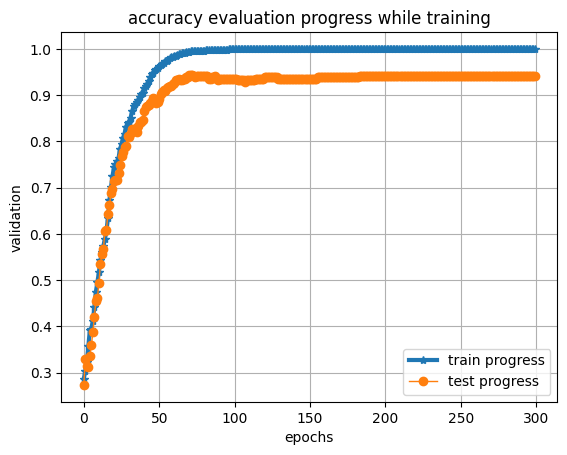

In [27]:
def plot_evaluation(train_progress, test_progress, title):
    '''function to plot the progress of training and testing data'''

    # convert the train accuracy list into numpy array.
    train_line_val = np.array([val for val in train_progress])
    # convert the train accuracy list into numpy array.
    test_line_val = np.array([val for val in test_progress])

    # plot the progress of training accuracy over epochs.
    train_progress, = plt.plot((range(len(train_line_val))), train_line_val, label="train progress", marker="*", linewidth=3)
    # plot the progress of testing accuracy over epochs.
    test_progress, = plt.plot((range(len(test_line_val))), test_line_val, label="test progress", marker="o", linewidth=1)

    # set the legend parameters.
    plt.legend(loc="best", handles=[train_progress, test_progress])
    # write the figure title.
    plt.title(title)
    # write the label of x axis.
    plt.xlabel("epochs")
    # write the label of y axis.
    plt.ylabel("validation")
    # add grid to the figure
    plt.grid(which='major')
    # to show the figure and remove any unwanted appered words
    plt.show()

plot_evaluation(evaluations_progress[:, 0, 0], evaluations_progress[:, 1, 0], 'accuracy evaluation progress while training')

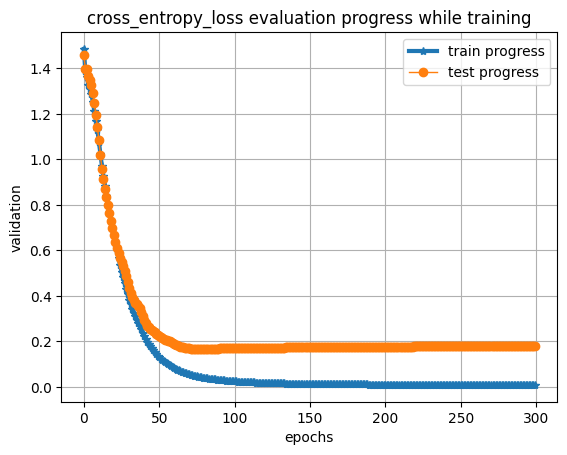

In [28]:
plot_evaluation(evaluations_progress[:, 0, 1], evaluations_progress[:, 1, 1], 'cross_entropy_loss evaluation progress while training')

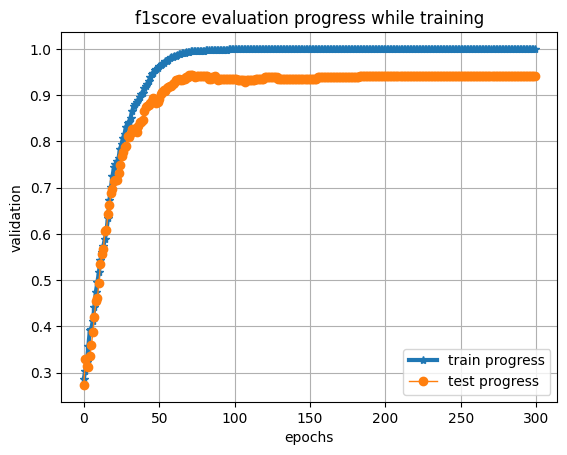

In [29]:
plot_evaluation(evaluations_progress[:, 0, 2], evaluations_progress[:, 1, 2], 'f1score evaluation progress while training')

In [30]:
# to change to this directory
%cd /content/drive/MyDrive/maids.cc/data
# path to the saving file
PATH = '/content/drive/MyDrive/maids.cc/data/pytorch_model.sav'

# saving the model using pytorch refer to https://pytorch.org/tutorials/beginner/saving_loading_models.html
#torch.save(model, PATH)

# loading the model when needed
# Model class must be defined somewhere
loaded_model = torch.load(PATH)
loaded_model.eval()



# # # #save the trained model to disk
filename = 'pytorch_model_.sav'
#joblib.dump(model, filename)
# # # # to load the model from disk
pytorch_model_ = joblib.load(filename)



# # # another way to save the trained model
filename = 'pytorch_model.sav'
#pickle.dump(model, open(filename, 'wb'))
# # # # to load the model from disk
pytorch_model = pickle.load(open(filename, 'rb'))

/content/drive/MyDrive/maids.cc/data


In [ ]:
# preprocessing the data in the inference time
preprocessor_1 = make_column_transformer((MinMaxScaler(feature_range=(0, 3)), ["ram"]), remainder="passthrough")
preprocessor_2 = make_column_transformer(
     (IterativeImputer(random_state=seed, tol=1e-5, max_iter=55), slice(0, 20)), remainder="passthrough")
preprocessor_3 = make_column_transformer((StandardScaler(), slice(1, 20)), remainder="passthrough")
pipe = make_pipeline(preprocessor_1, preprocessor_2, preprocessor_3)
# apply the needed transformations over the testing data
xtest = pipe.transform(xtest_unprocessed)
class CollectedData(Dataset):
    '''create the class to deal with the data convert them into torch tensors, getting the data item and getting the length of the data'''
    def __init__(self, x, y):
        self.data = torch.tensor(x, dtype=torch.float32)
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]
    def __getitem__(self, idx):
        '''return the data sample given the index'''
        return (self.data[idx].float(), self.label[idx]#.float()
        )
    def __len__(self):
        '''function to return the length of the dataset'''
        return self.n_smpl
#compine the features and the corresponding labels into one object
test_set = CollectedData(xtest, ytest)